In [58]:
%matplotlib inline
import pymongo
from pymongo import MongoClient
import matplotlib
matplotlib.rcParams.update({'font.size': 32,'image.cmap':'set3'})
import matplotlib.pyplot as plt
import numpy
from pprint import pprint
from collections import defaultdict, OrderedDict
from datetime import datetime, timedelta
from functools import partial
import time
import re
db = MongoClient('localhost').condor

In [96]:
db.condor_history.find_one({'GlobalJobId':{ '$regex': 'sub' } })

{'BytesRecvd': 32787.0,
 'BytesSent': 3843.0,
 'ClusterId': 100,
 'Cmd': '/scratch/tmp/kjero/MillipedeScansParallel/condor/exec/RUNID-119739_EVENTID-41603205_16_1685_36_0.sh',
 'CommittedTime': 7,
 'CompletionDate': 1426596794,
 'CumulativeSlotTime': 7.0,
 'DAGManJobId': 33,
 'DiskUsage_RAW': 102,
 'EnteredCurrentStatus': 1426596794,
 'ExecutableSize_RAW': 8,
 'ExitBySignal': False,
 'ExitCode': 2,
 'ExitStatus': 0,
 'GlobalJobId': 'sub-1.icecube.wisc.edu#100.0#1426596761',
 'ImageSize_RAW': 8,
 'JobCurrentStartDate': 1426596787,
 'JobStartDate': 1426596787,
 'JobStatus': 4,
 'LastRemoteHost': 'glidein_17311_73793984@acas1555.usatlas.bnl.gov',
 'MATCH_EXP_JOBGLIDEIN_ResourceName': 'BNL-ATLAS',
 'NumJobStarts': 1,
 'NumShadowStarts': 1,
 'Owner': 'kjero',
 'ProcId': 0,
 'QDate': 1426596761,
 'RemoteSysCpu': 0.0,
 'RemoteUserCpu': 0.0,
 'RemoteWallClockTime': 7.0,
 'RequestCpus': 1,
 'RequestDisk': 512000,
 'RequestMemory': 2000,
 'ResidentSetSize_RAW': 0,
 '_id': ObjectId('58a6f544db39d

In [14]:
gpu_ratios = {
    'DESY':1.67,
    'WIPAC':1.9,
    'parallel':0.6,
    'xsede-osg':0.6,
    'Bridges':1.67,
    'Crane':0.6,
    'Guillimin':0.6,
    'Comet':1.67,
    'NPX':1.9,
    'GZK':3.5,
    'osgconnect':0.6
}

In [88]:
datetime.fromtimestamp(1480357355)

datetime.datetime(2016, 11, 28, 12, 22, 35)

In [38]:
def timekey(t):
    return datetime.fromtimestamp(t).strftime('%Y-%m')
def make2list():
    return [0.,0.]                              
def make3list():
    return [0.,0.,0]
def makedatedict(start,end,default=make2list):
    return {timekey(t):default() for t in range(int(start),int(end),3600*24*28)}

In [66]:
time.mktime((2017,1,0,0,0,0,0,0,0))

1483164000.0

In [97]:
projection = ['MATCH_EXP_JOBGLIDEIN_ResourceName','EnteredCurrentStatus',
              'RemoteWallClockTime','CumulativeSlotTime','NumJobStarts',
              'ExitCode','ExitBySignal','ExitSignal','JobStatus','LastJobStatus',
              'LastHoldReason','LastRemoteHost']
start = time.mktime((2016,1,1,0,0,0,0,0,0))
end = time.mktime((2017,1,1,0,0,0,0,0,0))
filter = {'EnteredCurrentStatus':{'$gte':start,
                                  '$lt':end},
          #'LastRemoteHost':{'$regex':'glidein_'},
          #'LastRemoteHost':{'$not': re.compile('glidein_') },
          'Requestgpus':1,
          'MATCH_EXP_JOBGLIDEIN_ResourceName':{'$nin':['NPX','GZK','WIPAC']},
          'LastRemoteHost':{'$not': re.compile('gzk') },
         }
# by day
good_completed = defaultdict(partial(makedatedict,start,end,make2list))
bad_completed = defaultdict(partial(makedatedict,start,end,make2list))
bad_removed_run = defaultdict(partial(makedatedict,start,end,make2list))
bad_removed_hold_memory = defaultdict(partial(makedatedict,start,end,make2list))
bad_removed_hold_transfer = defaultdict(partial(makedatedict,start,end,make2list))
bad_removed_hold = defaultdict(partial(makedatedict,start,end,make2list))
bad_removed_other = defaultdict(partial(makedatedict,start,end,make2list))
bad_signal = defaultdict(partial(makedatedict,start,end,make2list))
bad_signal_glidein = defaultdict(partial(makedatedict,start,end,make2list))
bad_signal_user = defaultdict(partial(makedatedict,start,end,make2list))
bad_restarts = defaultdict(make3list)
no_restarts = defaultdict(partial(defaultdict,int))
start_time = time.time()
for i,row in enumerate(db.condor_history.find(filter=filter,projection=projection)):
    try:
        if 'MATCH_EXP_JOBGLIDEIN_ResourceName' not in row:
            continue
        site = row['MATCH_EXP_JOBGLIDEIN_ResourceName']
        #if site in ('CHTC','HEP') or 'WISC' in site:
        #    continue
        if site not in ('CHTC','HEP') and 'WISC' not in site:
            continue
        date = timekey(row['EnteredCurrentStatus'])
        if not row['ExitBySignal']:
            if row['JobStatus'] == 4:
                if row['ExitCode'] == 0:
                    good_completed[site][date][0] += float(row['RemoteWallClockTime'])
                    good_completed[site][date][1] += 1
                else:
                    bad_completed[site][date][0] += float(row['RemoteWallClockTime'])
                    bad_completed[site][date][1] += 1
            elif row['JobStatus'] == 3:
                if row['LastJobStatus'] == 2:
                    bad_removed_run[site][date][0] += float(row['RemoteWallClockTime'])
                    bad_removed_run[site][date][1] += 1
                elif row['LastJobStatus'] == 5:
                    if 'LastHoldReason' in row and 'memory' in row['LastHoldReason'].lower():                        
                        bad_removed_hold_memory[site][date][0] += float(row['RemoteWallClockTime'])
                        bad_removed_hold_memory[site][date][1] += 1
                    elif 'LastHoldReason' in row and 'failed to receive' in row['LastHoldReason'].lower():                        
                        bad_removed_hold_transfer[site][date][0] += float(row['RemoteWallClockTime'])
                        bad_removed_hold_transfer[site][date][1] += 1
                    else:
                        bad_removed_hold[site][date][0] += float(row['RemoteWallClockTime'])
                        bad_removed_hold[site][date][1] += 1
                else:
                    bad_removed_other[site][date][0] += float(row['RemoteWallClockTime'])
                    bad_removed_other[site][date][1] += 1
        else:
            if row['ExitSignal'] in (6,11,7,8):
                bad_signal_user[site][date][0] += float(row['RemoteWallClockTime'])
                bad_signal_user[site][date][1] += 1
            elif row['ExitSignal'] in (12,9,15):
                bad_signal_glidein[site][date][0] += float(row['RemoteWallClockTime'])
                bad_signal_glidein[site][date][1] += 1
            else:
                bad_signal[site][date][0] += float(row['RemoteWallClockTime'])
                bad_signal[site][date][1] += 1
        
        if row['NumJobStarts'] > 1:
            bad_restarts[date][0] += float(row['CumulativeSlotTime'])-float(row['RemoteWallClockTime'])
            bad_restarts[date][1] += 1
            bad_restarts[date][2] += int(row['NumJobStarts'])
        else:
            no_restarts[site][date] += 1
    except:
        print(row)
        raise
print(time.time()-start_time)

271.83271312713623


In [98]:
bad_all = defaultdict(partial(defaultdict,make2list))
bad_by_type = defaultdict(partial(defaultdict,make2list))
bad_categories = OrderedDict([
        ('Completed - Exit != 0', bad_completed),
        ('Removed', bad_removed_run),
        ('Hold Memory', bad_removed_hold_memory),
        ('Hold Transfer', bad_removed_hold_transfer),
        ('Hold Other', bad_removed_hold),
        ('Removed Other', bad_removed_other),
        ('User SIGSEGV', bad_signal_user),
        ('Glidein Walltime', bad_signal_glidein),
        ('Signal Other', bad_signal),
])
for name,cat in bad_categories.items():
    for k in cat:
        for d in cat[k]:
            bad_all[k][d][0] += cat[k][d][0]
            bad_all[k][d][1] += cat[k][d][1]
            bad_by_type[name][d][0] += cat[k][d][0]
            bad_by_type[name][d][0] += cat[k][d][1]

In [99]:
pprint(good_completed.keys())

dict_keys(['CS_WISC', 'CHTC', 'HEP_WISC', 'CLOUD_WISC', 'WISC'])


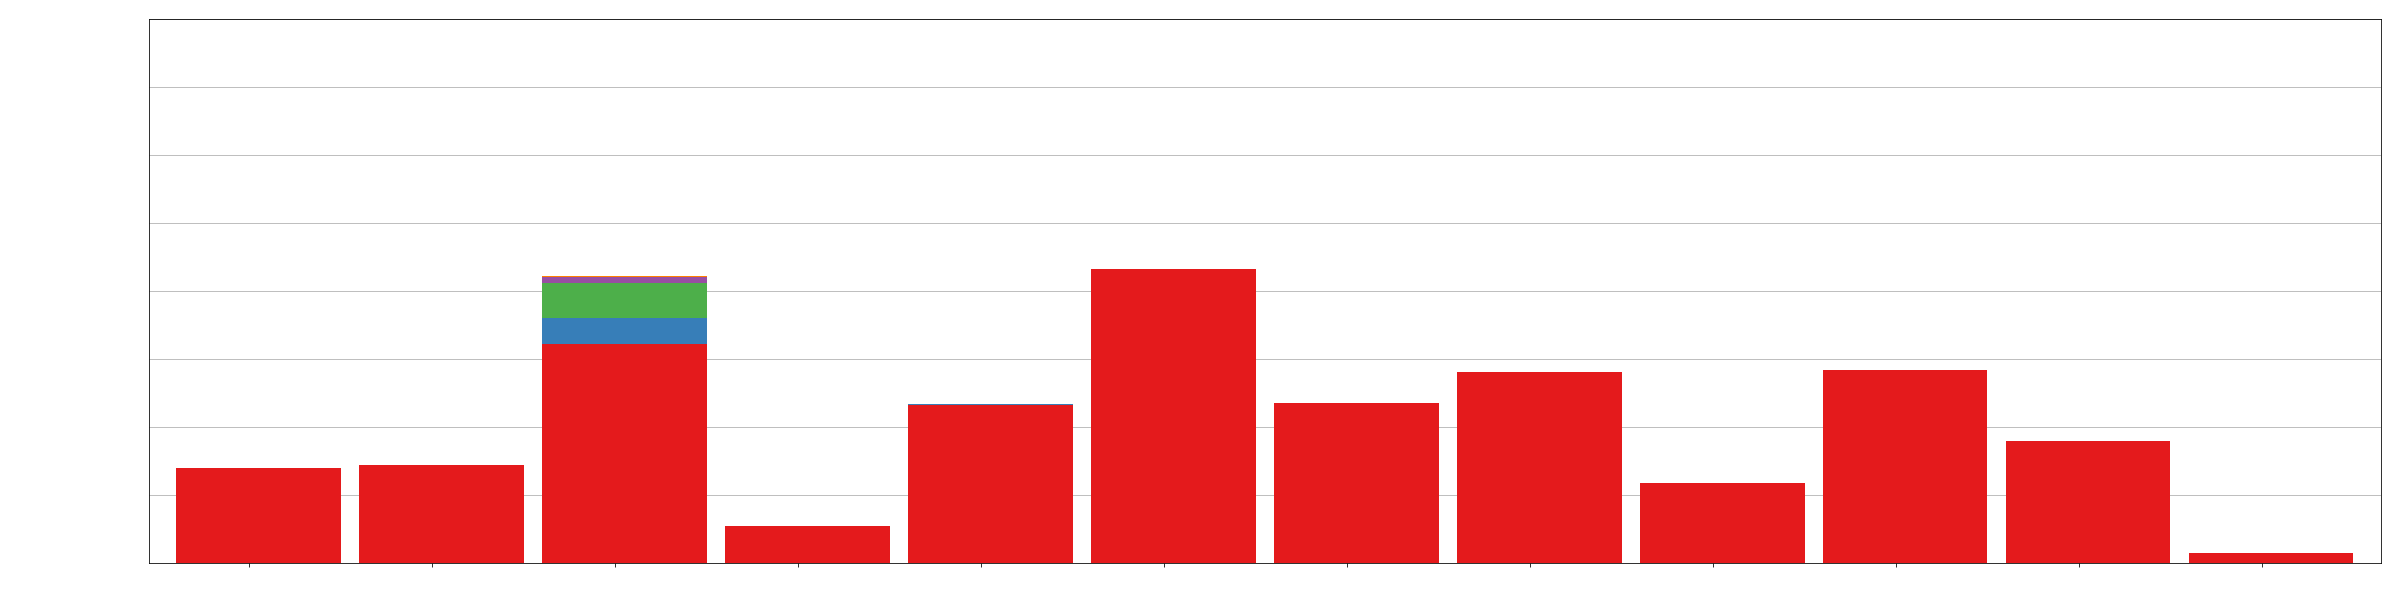

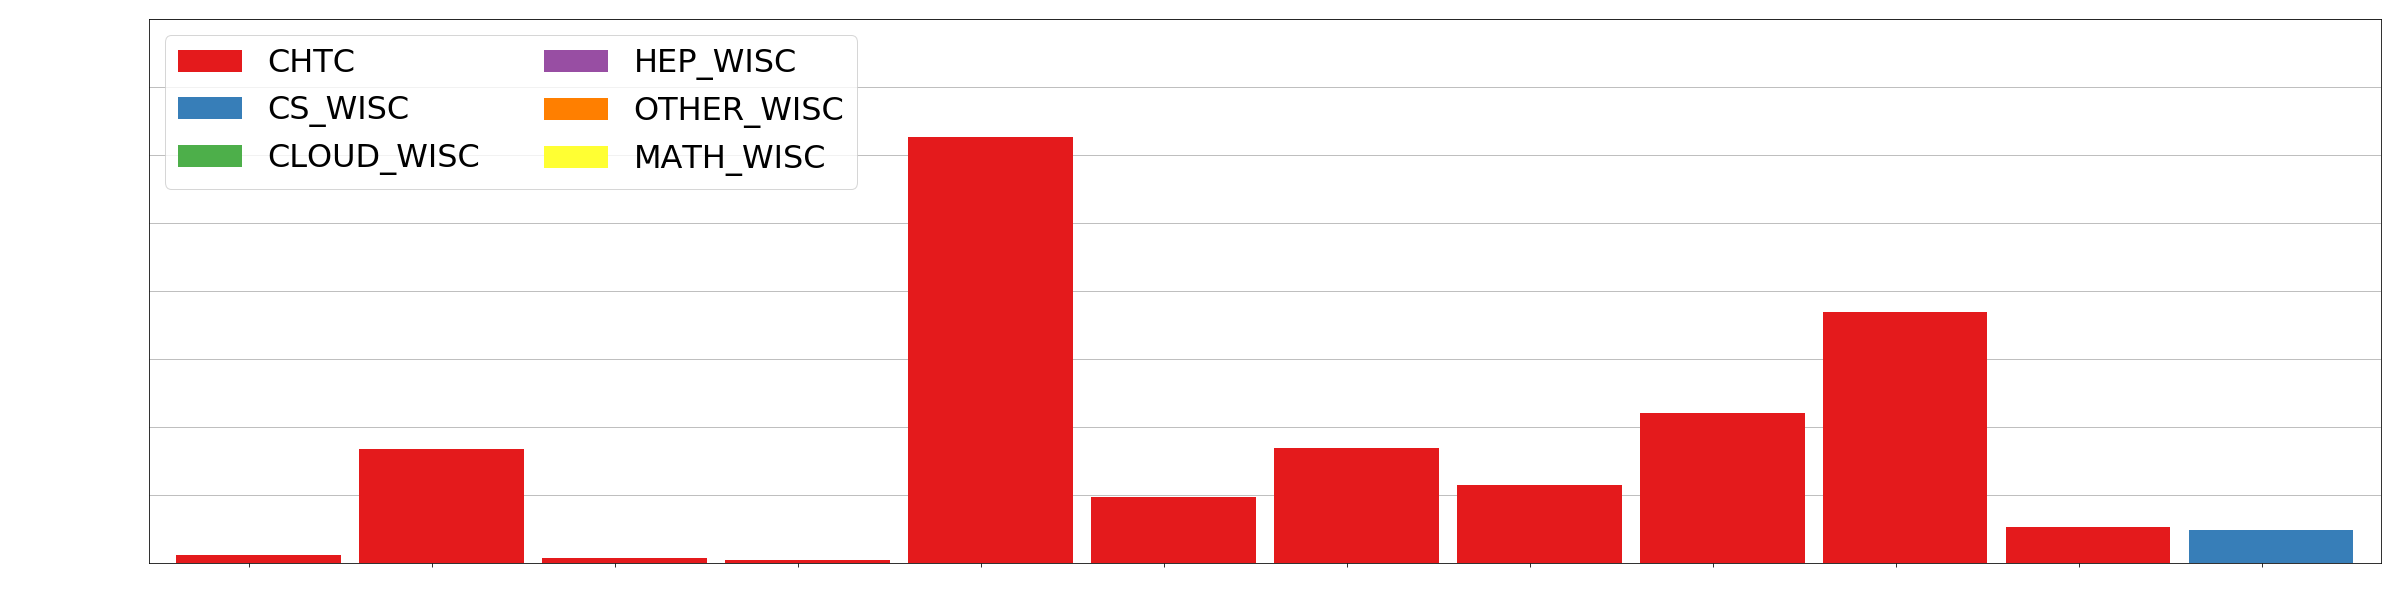

In [107]:
categories = OrderedDict([
    ('Goodput', good_completed),
    ('Badput', bad_all),
])
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#a6cee3','#999999','#fb9a99',]
all_time_sites = defaultdict(float)
for category in categories.values():
    for k,new_k in [('CA-MCGILL-CLUMEQ-T2','Guillimin'),
                    ('parallel','Alberta'),
                    ('Sandhills','Nebraska'),
                    ('Tusker','Nebraska'),
                    ('Crane','Nebraska'),
                    ('SU-OG-CE','SU-OG'),
                    ('SU-OG-CE1','SU-OG'),
                    ('SU-OG-CE2','SU-OG'),
                    ('jasper','Alberta'),
                    ('CA-SCINET-T2','CA-Toronto'),
                    ('Guillimin','CA-McGill'),
                    ('T2B_BE_IIHE','IIHE'),
                    ('DESY-ZN','DESY'),
                    ('DESY-HH','DESY'),
                    ('GPGrid','FNAL'),
                    ('USCMS-FNAL-WC1','FNAL'),
                    ('IceCube_DE_Dortmund_udo-ce08','Dortmund'),
                    ('UNI-DORTMUND','Dortmund'),
                    ('LIDO_Dortmund','Dortmund'),
                    ('wuppertalprod','Wuppertal'),
                    #('Comet','UCSDT2'),
                    ('mainzgrid','Mainz'),
                    ('mainz','Mainz'),
                    ('Mainz','IceCube-Mainz'),
                    ('UKI-LT2-QMUL','IceCube-Manchester'),
                    ('UKI-NORTHGRID-MAN-HEP','IceCube-Manchester'),
                    ('Dortmund','IceCube-Dortmund'),
                    ('DESY','IceCube-DESY'),
                    ('CA-Toronto','IceCube-CA-Toronto'),
                    ('CA-McGill','IceCube-CA-McGill'),
                    ('Alberta','IceCube-CA-Alberta'),
                    ('Wuppertal','IceCube-Wuppertal'),
                    ('RWTH-Aachen','IceCube-Aachen'),
                    ('BEgrid-ULB-VUB','IceCube-Brussels'),
                    ('IIHE','IceCube-IIHE'),
                    ('Comet','XSEDE-Comet'),
                    ('xsede-osg','XSEDE-OSG'),
                    ('osgconnect','OSGConnect'),
                    ('WISC','OTHER_WISC'),
                    ('AGLT2','IceCube-Michigan'),
                   ]:
        for d in category[k]:
            category[new_k][d][0] += category[k][d][0]
            category[new_k][d][1] += category[k][d][1]
        del category[k]
    for site in category:
        all_time_sites[site] += sum(category[site][d][0] for d in category[site])
top10 = sorted(all_time_sites,key=lambda k:all_time_sites[k],reverse=True)[:9]+['Other']
top10 = sorted(top10,key=lambda k:(100000 if 'IceCube' in k else 10 if 'XSEDE' in k or 'OSG' in k else 1)*all_time_sites[k],reverse=True)
top10 = OrderedDict((t,c) for t,c in zip(top10,colors))

for title,category in categories.items():
    x = sorted(set(x for k in category for x in category[k].keys()))
    xx = numpy.arange(len(x))
    y = {k:numpy.array([category[k][d][0]/3600 for d in x]) for k in category}
    #pprint(y.keys())
    other = numpy.sum([y[k] for k in y if k not in top10], axis=0)

    legend = [k for k in top10 if k in y]
    if other.any():
        legend.append('Other')
    width = .9
    plots = []
    fig, ax = plt.subplots(figsize=(40, 10))
    #ax.set_title(title,color='white')
    ax.set_xticks(xx-.05)
    ax.set_xticklabels(x, color='white')
    ax.get_yaxis().set_tick_params(colors='white')
    #ax.set_xlabel('Month', labelpad=10, color='white', fontsize=44)
    ax.set_ylabel('GPUhours', labelpad=10, color='white', fontsize=44)
    ax.get_yaxis().grid(b=True, which='major')
    ax.set_axisbelow(True)
    bottom = numpy.zeros(len(x))
    for i,k in enumerate(legend):
        if k == 'Other':
            plots.append(ax.bar(xx, other, width, bottom=bottom, color=top10[k]))
            bottom += other
        else:
            plots.append(ax.bar(xx, y[k], width, bottom=bottom, color=top10[k]))
            bottom += y[k]
    #labels = ax.get_xticklabels()
    #plt.setp(labels, rotation=45, fontsize=15, horizontalalignment='right')
    plt.xlim([-.6,len(xx)-.4])
    plt.ylim([0,4000])
    if title != 'Goodput':
        plt.legend(plots, legend, loc='upper left', ncol=2)

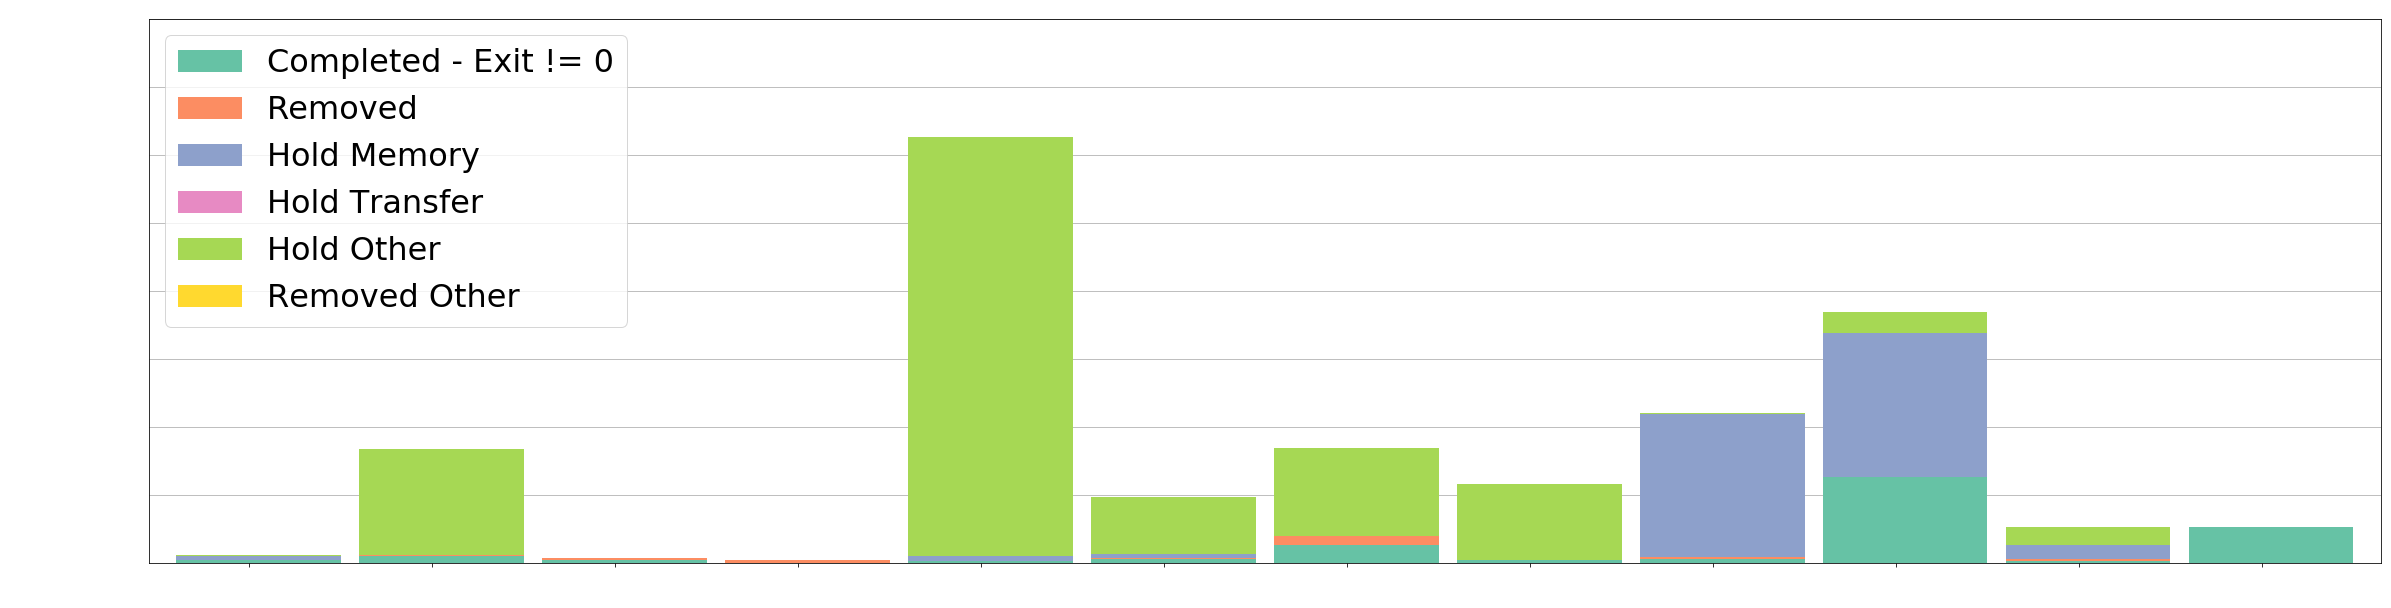

In [105]:
categories = OrderedDict([
    ('Bad by type', bad_by_type),
])
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']
all_time_sites = defaultdict(float)
for category in categories.values():
    for site in category:
        all_time_sites[site] += sum(category[site][d][0] for d in category[site])
top10 = bad_categories.keys()
top10 = OrderedDict((t,c) for t,c in zip(top10,colors))

for title,category in categories.items():
    x = sorted(set(x for k in category for x in category[k].keys()))
    xx = numpy.arange(len(x))
    y = {k:numpy.array([category[k][d][0]/3600 for d in x]) for k in category}

    legend = [k for k in top10 if k in y]
    width = .9
    plots = []
    fig, ax = plt.subplots(figsize=(40, 10))
    #ax.set_title(title,color='white')
    ax.set_xticks(xx-.05)
    ax.set_xticklabels(x, color='white')
    ax.get_yaxis().set_tick_params(colors='white')
    #ax.set_xlabel('Month', labelpad=10, color='white', fontsize=44)
    ax.set_ylabel('CPUhours', labelpad=10, color='white', fontsize=44)
    ax.get_yaxis().grid(b=True, which='major')
    ax.set_axisbelow(True)
    bottom = numpy.zeros(len(x))
    for i,k in enumerate(legend):
        if k == 'Other':
            plots.append(ax.bar(xx, other, width, bottom=bottom, color=top10[k]))
            bottom += other
        else:
            plots.append(ax.bar(xx, y[k], width, bottom=bottom, color=top10[k]))
            bottom += y[k]
    #labels = ax.get_xticklabels()
    #plt.setp(labels, rotation=45, fontsize=15, horizontalalignment='right')
    plt.xlim([-.6,len(xx)-.4])
    plt.ylim([0,4000])
    plt.legend(plots, legend, loc='upper left', ncol=1)

(-0.6, 5.6)

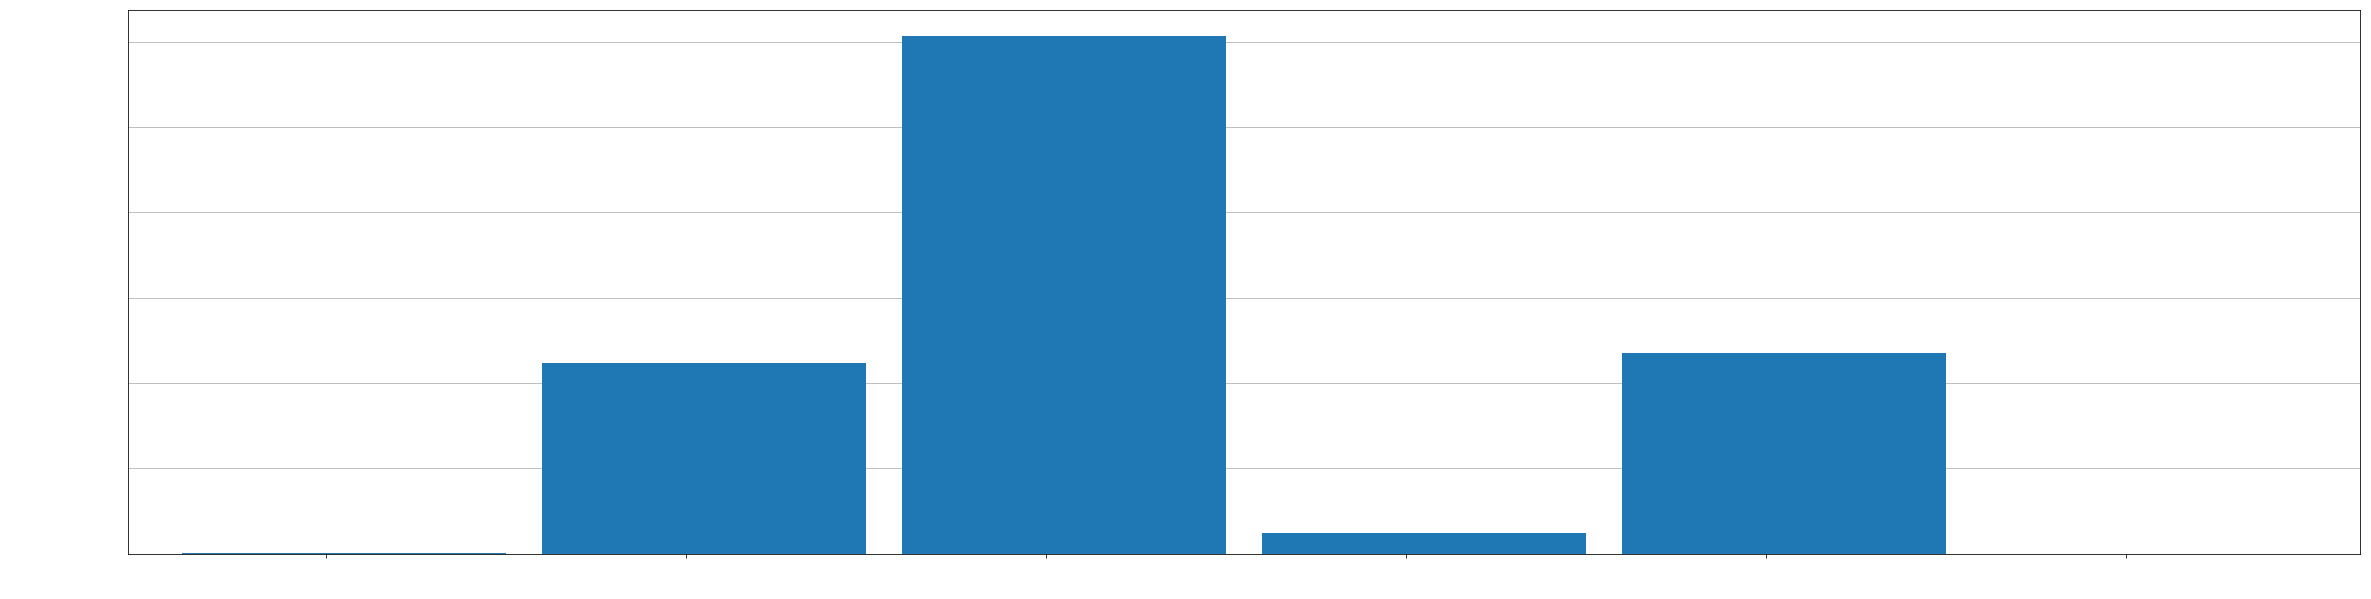

In [56]:
x = sorted(set(bad_restarts))
xx = numpy.arange(len(x))
y = [bad_restarts[d][0]/3600 for d in x]

width = .9
plots = []
fig, ax = plt.subplots(figsize=(40, 10))
#ax.set_title(title,color='white')
ax.set_xticks(xx-.05)
ax.set_xticklabels(x, color='white')
ax.get_yaxis().set_tick_params(colors='white')
#ax.set_xlabel('Month', labelpad=10, color='white', fontsize=44)
ax.set_ylabel('GPUhours', labelpad=10, color='white', fontsize=44)
ax.get_yaxis().grid(b=True, which='major')
ax.set_axisbelow(True)
bottom = numpy.zeros(len(x))
ax.bar(xx, y, width)
#labels = ax.get_xticklabels()
#plt.setp(labels, rotation=45, fontsize=15, horizontalalignment='right')
plt.xlim([-.6,len(xx)-.4])
#plt.ylim([0,80000])

In [34]:
del bad_restarts[0]

In [8]:
sum(good_completed[k][d][0] for k in good_completed for d in good_completed[k])/3600

647075.4563888889

In [9]:
sum(bad_all[k][d][0] for k in bad_all for d in bad_all[k])/3600

197953.5575